In [1]:
import itertools
import numpy as np
from math import factorial
from sklearn.metrics import accuracy_score
import xgboost as xgb
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
import multiprocessing as mp
import shap
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import lime


In [2]:
data = pd.read_csv('C:/data/df_2015_MCAR_0.8.csv')

# Map: [1, 2, 3, 4, 7, 9] -> [0, 1, 2, 3, 4, 5]
class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 9: 5}

data['diabetes'] = data['diabetes'].map(class_mapping)

data = data.astype(int, errors='ignore')
data = data.set_index('Unnamed: 0') ##This line should be commented out for the complete dataset.

data
#print("Unique values in target:", data['diabetes'].unique())  

,high_blood_pressure,high_cholesterol,checked_cholesterol,bmi,smoker,stroke,heart_disease,physical_activity,fruit_consumption,vegetable_consumption,...,medical_cost,general_health,mental_health,physical_health,walking_difficulty,sex,age,education,income,diabetes
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2
1,1.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,...,1.0,3.0,88.0,NaN,NaN,NaN,7.0,NaN,NaN,2
2,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,88.0,NaN,2.0,11.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427162,2.0,NaN,1.0,1842.0,2.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
427163,1.0,NaN,NaN,2834.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
427164,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [3]:
X = data.drop(columns=['diabetes'])  # Features

y = data['diabetes']  # Target
y = y.astype(int, errors='ignore')


In [4]:
##XGBoost stuff
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(objective='multi:softprob', num_class=6, n_estimators=100, max_depth=3, eta=0.1)
clf.fit(X_train, y_train)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=6, ...)

In [5]:
##SHAP

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)



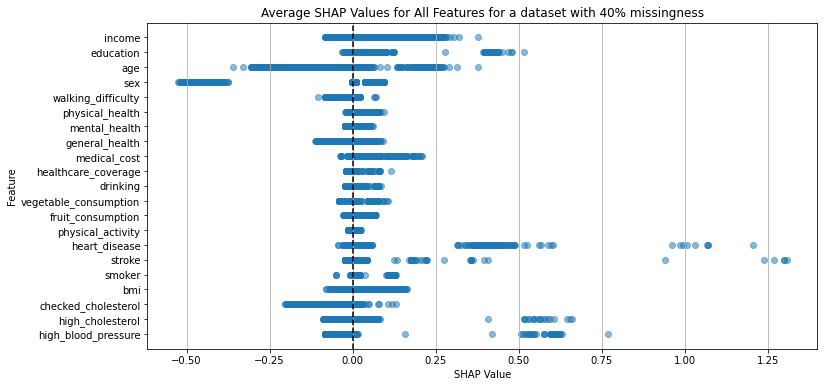

In [6]:

if isinstance(shap_values, list):
    shap_values_avg = np.mean(np.array(shap_values), axis=0) 
else:
    shap_values_avg = shap_values  

shap_values_flat = shap_values_avg.reshape(-1, shap_values_avg.shape[1])

shap_values_df = pd.DataFrame(shap_values_flat, columns=X.columns)

shap_long = shap_values_df.melt(var_name='Feature', value_name='SHAP Value')

plt.figure(figsize=(12, 6))
plt.scatter(shap_long['SHAP Value'], shap_long['Feature'], alpha=0.5)

plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.title('Average SHAP Values for All Features for a dataset with 40% missingness')

plt.axvline(0, color='black', linestyle='--')
plt.grid(axis='x')
plt.show()

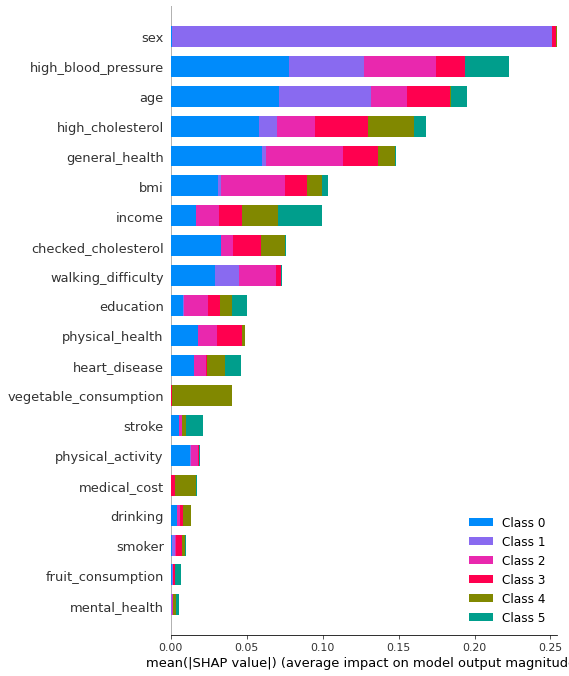

In [7]:
shap.summary_plot(shap_values, X_test)
##not good plots.

In [8]:
    
mean_df = shap_values_df.mean().to_frame()

(-0.2, 0.0)

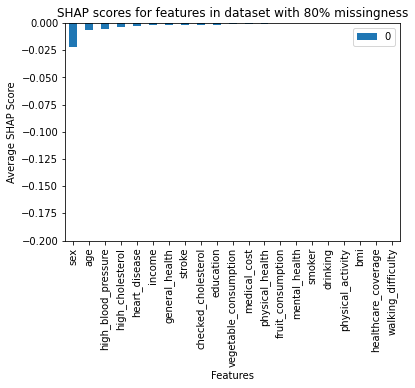

In [9]:
mean_df = mean_df.sort_values(0,ascending=True)
##better plots
mean_df.plot(kind='bar')
plt.title('SHAP scores for features in dataset with 80% missingness')
plt.ylabel('Average SHAP Score')
plt.xlabel('Features')
plt.ylim(-0.20, 0)

# LIME ANALYSIS


In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns,
                                                   class_names=[str(i) for i in range(6)],  # Assuming 6 classes
                                                   discretize_continuous=False)

lime_scores = {col: [] for col in X_test.columns}


In [11]:
X_test.fillna(X_test.mean(), inplace=True)

X_test = X_test.round().astype(int)

##This cell is for the datasets which have missingness

In [12]:


n_samples = 1000 
for i in range(n_samples):
    instance = X_test.iloc[i].values
    explanation = explainer.explain_instance(instance, clf.predict_proba, num_features=len(X_train.columns))
    
    listt = explanation.as_list()
    selected_features_with_scores = []

    for entry, score in listt:
        parts = entry.split()

        if len(parts) > 1: 
            if parts[0].replace('.', '', 1).isdigit():  
                feature_name = parts[2]  
            else:
                feature_name = parts[0]  
        else:
            feature_name = parts[0] 

        selected_features_with_scores.append((feature_name, score))
    
    for feature, score in selected_features_with_scores:
        
        lime_scores[feature].append(score)

        
global_lime_scores = {feature: np.mean(scores) for feature, scores in lime_scores.items()}

global_lime_df = pd.DataFrame(list(global_lime_scores.items()), columns=['Feature', 'LIME Score'])



In [13]:
global_lime_df

,Feature,LIME Score
0,high_blood_pressure,-4.524365e-04
1,high_cholesterol,-5.823308e-05
2,checked_cholesterol,1.363582e-06
3,bmi,5.834712e-04
4,smoker,-2.761218e-07
5,stroke,-1.976044e-04
6,heart_disease,-1.628159e-04
7,physical_activity,-1.546201e-04
8,fruit_consumption,-1.135436e-04
9,vegetable_consumption,-3.737402e-06


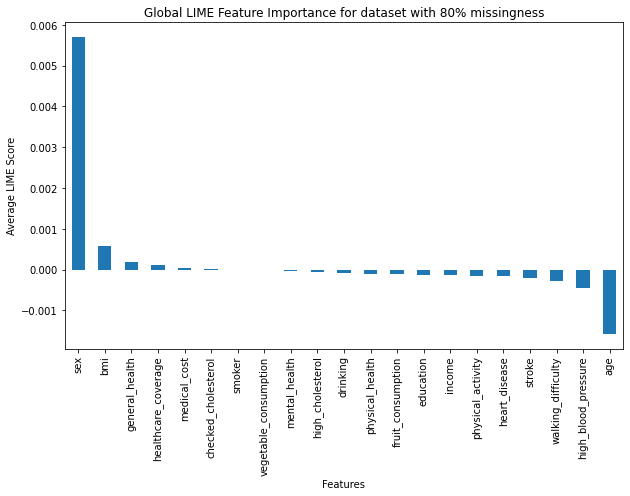

In [14]:
global_lime_df = global_lime_df.set_index('Feature').sort_values('LIME Score', ascending=False)

plt.figure(figsize=(10, 6))
global_lime_df['LIME Score'].plot(kind='bar')
plt.title('Global LIME Feature Importance for dataset with 80% missingness')
plt.ylabel('Average LIME Score')
plt.xlabel('Features')
plt.show()